In [6]:
import re
from pathlib import Path
from typing import Optional, Tuple, Dict, Any, Sequence

import numpy as np

import jax
import jax.lax
import jax.numpy as jnp
import optax
from flax.training.train_state import TrainState
from flax.training import checkpoints
from flax import linen as nn
from jax.flatten_util import ravel_pytree

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings(
    "ignore",
    message=(
        "Couldn't find sharding info under RestoreArgs.*"
    ),
    category=UserWarning,
    module="orbax.checkpoint.type_handlers"
)

data_dir = "data"
model_dir = "./models"
model_prefix = "rbm_amp_202506032030_0"

print(f"Data resides in                         : {data_dir}")
print(f"Amplitude RBM checkpoint to be loaded   : {model_dir}/{model_prefix}")

Data resides in                         : data
Amplitude RBM checkpoint to be loaded   : ./models/rbm_amp_202506032030_0


In [7]:
class MultiBasisDataLoader:
    char2id = {'Z': 0, 'X': 1, 'Y': 2}

    def __init__(self,
                 data_dict: dict[str, jnp.ndarray],
                 batch_size: int = 128,
                 shuffle: bool = True,
                 drop_last: bool = False,
                 seed: int = 0):

        lengths = [v.shape[0] for v in data_dict.values()]
        if len(set(lengths)) != 1:
            raise ValueError(f"All arrays must have equal length, got: {lengths}")

        self._bases = list(data_dict.keys())
        self._arrays = list(data_dict.values())

        self.n_visible = data_dict[self._bases[0]].shape[1]
        self.total_samples = lengths[0]
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.rng = np.random.default_rng(seed)

        self._encoded_bases = []
        for basis_str in self._bases:
            if len(basis_str) != self.n_visible:
                raise ValueError(f"All basis strings must have length {self.n_visible}. "
                                 f"Got '{basis_str}' length {len(basis_str)}.")
            enc = np.array([MultiBasisDataLoader.char2id[c] for c in basis_str],
                           dtype=np.int8)
            self._encoded_bases.append(enc)
        # Now self._encoded_bases is a list of np.int8 arrays, each shape (n_visible,)

        self.idx_slices = [
            (i, i + batch_size)
            for i in range(0, self.total_samples, batch_size)
            if not drop_last or (i + batch_size <= self.total_samples)
        ]

    def __iter__(self):
        self._order = np.arange(self.total_samples)
        if self.shuffle:
            self.rng.shuffle(self._order)
        self._slice_idx = 0
        return self

    def __next__(self) -> Tuple[jnp.ndarray, jnp.ndarray]:
        if self._slice_idx >= len(self.idx_slices):
            raise StopIteration

        s, e = self.idx_slices[self._slice_idx]
        self._slice_idx += 1

        batch_arrays = []
        for arr in self._arrays:
            # arr has shape (total_samples, n_visible)
            sub = arr[self._order[s:e], :]
            batch_arrays.append(sub)   # (batch_size, n_visible)

        data_array = jnp.stack(batch_arrays, axis=0)

        # basis_ids_array: shape (N_B, n_visible), dtype=int8
        basis_ids_array = jnp.stack(self._encoded_bases, axis=0) # (N_B, n_visible)

        return basis_ids_array, data_array  # ready for model.apply

    def __len__(self):
        return len(self.idx_slices)


def load_measurements(folder: str, file_pattern: str = "w_*.txt") -> dict[str, jnp.ndarray]:
    out: dict[str, jnp.ndarray] = {}

    for fp in Path(folder).glob(file_pattern):
        basis = fp.stem.split("_")[2]

        bitstrings = []
        with fp.open() as f:
            for line in f:
                bitstring = np.fromiter((c.islower() for c in line.strip()), dtype=np.float32)
                bitstrings.append(bitstring)

        arr = jnp.asarray(np.stack(bitstrings))
        if basis in out:
            out[basis] = jnp.concatenate([out[basis], arr], axis=0)
        else:
            out[basis] = arr

    return out

In [13]:
#### SOME HELPER FUNCTIONS

def get_computational_basis_vectors(num_qubits: int) -> jnp.ndarray:
    indices = jnp.arange(2 ** num_qubits, dtype=jnp.uint32)  # shape (2**n,)
    powers = 2 ** jnp.arange(num_qubits - 1, -1, -1, dtype=jnp.uint32)  # shape (n,)
    bits = (indices[:, None] & powers) > 0  # shape (2**n, n), bool
    return bits.astype(jnp.float32)

from functools import reduce

def construct_rotation_matrix(measurement_basis: jnp.ndarray) -> jnp.ndarray:
    SQRT2 = jnp.sqrt(2.0)
    single_qubit_rotation_matrices = jnp.stack([
        jnp.array([[1, 0], [0, 1]], dtype=jnp.complex64),               # Z
        jnp.array([[1, 1], [1, -1]], dtype=jnp.complex64) / SQRT2,      # X
        jnp.array([[1, -1j], [1j, -1]], dtype=jnp.complex64) / SQRT2    # Y
    ])  # (3, 2, 2)

    gates = single_qubit_rotation_matrices[measurement_basis]  # (n, 2, 2)

    def kron_all(a, b):
        return jnp.kron(a, b)

    return reduce(kron_all, gates)

def bitstring_to_int(bitstring: jnp.ndarray) -> jnp.ndarray:
    powers = 2 ** jnp.arange(bitstring.shape[-1] - 1, -1, -1)
    return jnp.sum(bitstring * powers, axis=-1).astype(jnp.int32)





class PairPhaseRBM(nn.Module):
    n_visible: int
    n_hidden: int

    def setup(self):
        zeros = lambda shape: jnp.zeros(shape, dtype=jnp.float32)
        self.W_amp = self.variable('amp', 'W_amp', zeros, (self.n_visible, self.n_hidden))
        self.b_amp = self.variable('amp', 'b_amp', zeros, (self.n_visible,))
        self.c_amp = self.variable('amp', 'c_amp', zeros, (self.n_hidden,))

        self.W_pha = self.param('W_pha', nn.initializers.normal(0.01), (self.n_visible, self.n_hidden))
        self.b_pha = self.param('b_pha', nn.initializers.zeros, (self.n_visible,))
        self.c_pha = self.param('c_pha', nn.initializers.zeros, (self.n_hidden,))

    def _free_energy_amp(self, v):
        return -(v @ self.b_amp.value) - jnp.sum(jax.nn.softplus(v @ self.W_amp.value + self.c_amp.value), -1)

    def _free_energy_pha(self, v):
        return -(v @ self.b_pha) - jnp.sum(jax.nn.softplus(v @ self.W_pha + self.c_pha), -1)

    @staticmethod
    def rotated_log_prob(rotation_amplitudes: jnp.ndarray, free_energy_amp: jnp.ndarray, free_energy_pha: jnp.ndarray) -> jnp.ndarray:
        exponent = -0.5 * free_energy_amp - 0.5j * free_energy_pha                     # (2**n,)
        values = rotation_amplitudes * jnp.exp(exponent)                          # Complex vector

        abs_vals = jnp.abs(values)
        max_log = jnp.max(jnp.log(abs_vals + 1e-30))                # Scalar for stability
        scaled_values = values * jnp.exp(-max_log)                  # Scale down before summing

        return 2 * (max_log + jnp.log(jnp.abs(jnp.sum(scaled_values)) + 1e-30))

    def __call__(self, measurement_tuple: Tuple) -> Tuple:
        measurement, basis = measurement_tuple
        # r_rotated_log_weight
        # the following three can be moved outside. the first two don't change ever per measurement, the third one only changes between gradient steps
        computational_basis_vectors = get_computational_basis_vectors(measurement.shape[0])  # (2**n, n)
        free_energy_amp = jax.vmap(self._free_energy_amp, (0,))(computational_basis_vectors)  # (2**n,)
        free_energy_pha = jax.vmap(self._free_energy_pha, (0,))(computational_basis_vectors)  # (2**n,)

        rotation_matrix = construct_rotation_matrix(basis)  # (2**n, 2**n)
        
        measurement_basis_amplitude_idx = bitstring_to_int(measurement)  # (B,)
        computational_basis_amplitudes = rotation_matrix[measurement_basis_amplitude_idx]  # (B, 2**n)

        rotated_log_prob = PairPhaseRBM.rotated_log_prob(computational_basis_amplitudes, free_energy_amp, free_energy_pha)
        return rotated_log_prob  # (B,)

In [14]:
# --- TEST: init and forward pass for PairPhaseRBM ---

# Model hyperparameters
visible_units = 10
hidden_units  = 10
batch_size    = 128

# Dummy input: one basis + one measurement
key = jax.random.PRNGKey(42)
basis_demo = jax.random.randint(key, (visible_units,), minval=0, maxval=3, dtype=jnp.int8)  # e.g. [1 0 2 ...]
data_demo  = jax.random.randint(key, (visible_units,), minval=0, maxval=2, dtype=jnp.int32).astype(jnp.float32)  # e.g. [0 1 1 ...]

# Init model
model = PairPhaseRBM(n_visible=visible_units, n_hidden=hidden_units)
params_demo = model.init(key, (data_demo, basis_demo))

# Forward pass
out = model.apply(params_demo, (data_demo, basis_demo))  # Should return scalar log prob
print("Rotated log-prob:", out)


Rotated log-prob: -15.371708


In [8]:

    def _single_basis_loss(self, measurements: jnp.ndarray, basis: jnp.ndarray) -> jnp.ndarray:
        rotated_log_weights = jax.vmap(lambda meas: self._single_sample_loss(meas, basis))(measurements)  # (B,)
        return jnp.mean(rotated_log_weights)

    def _multi_basis_loss(self, data_tuple: Tuple[jnp.ndarray, jnp.ndarray]) -> jnp.ndarray:
        basis_measurements, bases = data_tuple  # (N_B, B, n_visible), (N_B, n_visible)

        mean_per_basis = jax.vmap(self._single_basis_loss)(basis_measurements, bases)  # (N_B,)
        return -jnp.sum(mean_per_basis)

In [20]:
@jax.jit
def train_step_natural(
        state: TrainState,
        amp_vars: dict,
        data_tuple: Tuple[jnp.ndarray, jnp.ndarray],
        lr: float = 1e-3,
        eps: float = 1e-5,
) -> Tuple[TrainState, jnp.ndarray]:

    basis_batch, data_batch = data_tuple  # (N_B, n_visible), (N_B, B, n_visible)

    def full_loss_fn(params):
        # vmap over (basis, measurements) pairs
        loss_per_basis = jax.vmap(
            lambda basis, measurements: jnp.mean(
                jax.vmap(lambda meas: state.apply_fn({'params': params, 'amp': amp_vars}, (meas, basis)))(measurements)
            )
        )(basis_batch, data_batch)
        return -jnp.sum(loss_per_basis)

    loss_val = full_loss_fn(state.params)

    # Per-sample loss needed for Fisher
    def per_sample_loss(params, basis, measurement):
        return state.apply_fn({'params': params, 'amp': amp_vars}, (measurement, basis))

    grad_fn = jax.vmap(
        jax.vmap(jax.grad(per_sample_loss), in_axes=(None, None, 0)),
        in_axes=(None, 0, 0)
    )
    per_sample_grads = grad_fn(state.params, basis_batch, data_batch)

    def flatten(g): return g.reshape(-1, *g.shape[2:])
    flat_grads = jax.tree_map(flatten, per_sample_grads)

    fisher_diag = jax.tree_map(lambda g: jnp.mean(g ** 2, axis=0), flat_grads)
    mean_grad   = jax.tree_map(lambda g: jnp.mean(g,     axis=0), flat_grads)

    flat_grad, unravel = ravel_pytree(mean_grad)
    flat_fisher, _     = ravel_pytree(fisher_diag)

    nat_flat  = -lr * flat_grad / (flat_fisher + eps)
    nat_grads = unravel(nat_flat)

    # simply use sgd for the optimizer and use the natgrads and state.apply_gradients(grads=grads)

    new_params = jax.tree_map(lambda p, ng: p + ng, state.params, nat_grads)
    new_state  = state.replace(params=new_params)

    return new_state, loss_val







def train_rbm_pha(
        state:   TrainState,
        amp_vars: Dict[str, jnp.ndarray],
        loader:  "MultiBasisDataLoader",
        num_epochs: int) -> Tuple[TrainState, Dict[int, float]]:

    metrics: Dict[str, float] = {}

    for epoch in range(num_epochs):
        tot_loss  = 0.0
        n_batches = 0

        for data_tuple in loader:                       # (basis_ids, data_array)
            state, loss = train_step_natural(state, amp_vars, data_tuple)
            tot_loss  += loss
            n_batches += 1

        avg_loss = float(tot_loss / n_batches)

        metrics[epoch] = dict(loss=avg_loss)

        print(f"Epoch {epoch+1}/{num_epochs} │ Loss: {avg_loss:.4f}")

    return state, metrics

In [21]:
data_dict = load_measurements(data_dir, "w_*.txt")

keys_pha = [k for k in data_dict if 'Z' in k and re.search(r'[XY]', k)]
dict_pha = {k: data_dict[k] for k in keys_pha}

In [22]:
params_amp = checkpoints.restore_checkpoint(ckpt_dir=str(Path(model_dir).resolve()), target=None, prefix=model_prefix)

amp_vars = {"W_amp": params_amp["W"], "b_amp": params_amp["b"], "c_amp": params_amp["c"]}

In [23]:
batch_size    = 6400
visible_units = 10
hidden_units  = 20
num_epochs    = 50
init_lr       = 1e-2
weight_decay  = 0.5

key = jax.random.PRNGKey(0)

model_pha = PairPhaseRBM(n_visible=visible_units, n_hidden=hidden_units)

# One dummy measurement and basis to initialize the model
dummy_basis = jnp.zeros((visible_units,), dtype=jnp.int8)            # shape (n_visible,)
dummy_meas  = jnp.zeros((visible_units,), dtype=jnp.float32)         # shape (n_visible,)

# Initialize using the __call__ method that expects a single (measurement, basis) tuple
vars_pha = model_pha.init(key, (dummy_meas, dummy_basis))            # Note: no batch dim here!

optim = optax.sgd(init_lr)

state_pha = TrainState.create(apply_fn=model_pha.apply, params=vars_pha['params'], tx=optim)

loader_pha = MultiBasisDataLoader(dict_pha, batch_size=batch_size, shuffle=True)

%time state_pha, metrics_pha = train_rbm_pha(state_pha, amp_vars, loader_pha, num_epochs)

/var/folders/v_/l0msh8452n10859t9wg_9zdc0000gq/T/ipykernel_75472/911532990.py:34: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  flat_grads = jax.tree_map(flatten, per_sample_grads)
/var/folders/v_/l0msh8452n10859t9wg_9zdc0000gq/T/ipykernel_75472/911532990.py:36: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  fisher_diag = jax.tree_map(lambda g: jnp.mean(g ** 2, axis=0), flat_grads)
/var/folders/v_/l0msh8452n10859t9wg_9zdc0000gq/T/ipykernel_75472/911532990.py:37: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  mean_grad   = jax.tree_map(lambda g: jnp.mean(g,     axis=0), flat_grads)
/var/folders/v_/l0msh8452n10859t9wg_9zdc0000gq/T/ipykernel_75472/911532990.py:45: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map 

Epoch 1/50 │ Loss: -81.1390
Epoch 2/50 │ Loss: -81.1263
Epoch 3/50 │ Loss: -81.1210
Epoch 4/50 │ Loss: -81.1093
Epoch 5/50 │ Loss: -81.0999
Epoch 6/50 │ Loss: -81.1098
Epoch 7/50 │ Loss: -81.1047
Epoch 8/50 │ Loss: -81.0996
Epoch 9/50 │ Loss: -81.0952
Epoch 10/50 │ Loss: -81.1024
Epoch 11/50 │ Loss: -81.0930
Epoch 12/50 │ Loss: -81.0851
Epoch 13/50 │ Loss: -81.0788
Epoch 14/50 │ Loss: -81.0739
Epoch 15/50 │ Loss: -81.0698
Epoch 16/50 │ Loss: -81.0663
Epoch 17/50 │ Loss: -81.0715
Epoch 18/50 │ Loss: -81.0635
Epoch 19/50 │ Loss: -81.0580
Epoch 20/50 │ Loss: -81.0548
Epoch 21/50 │ Loss: -81.0525
Epoch 22/50 │ Loss: -81.1026
Epoch 23/50 │ Loss: -81.0983
Epoch 24/50 │ Loss: -81.0931
Epoch 25/50 │ Loss: -81.0890
Epoch 26/50 │ Loss: -81.0873
Epoch 27/50 │ Loss: -81.0815
Epoch 28/50 │ Loss: -81.0864
Epoch 29/50 │ Loss: -81.0826
Epoch 30/50 │ Loss: -81.0870
Epoch 31/50 │ Loss: -81.0778
Epoch 32/50 │ Loss: -81.0711
Epoch 33/50 │ Loss: -81.0676
Epoch 34/50 │ Loss: -81.0748
Epoch 35/50 │ Loss: -81

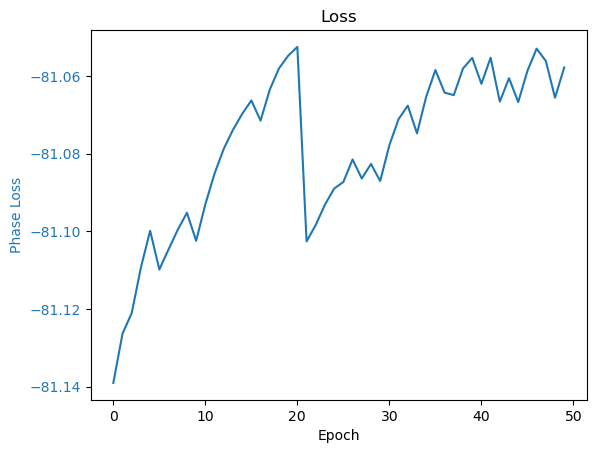

In [24]:
epochs = list(metrics_pha.keys())
loss_vals = [metrics_pha[e]['loss'] for e in epochs]

fig, ax1 = plt.subplots()

ax1.plot(epochs, loss_vals, label="Amplitude CD Loss", color="tab:blue")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Phase Loss", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

plt.title("Loss")
plt.show()

In [25]:
one_hot_states = jnp.eye(visible_units, dtype=jnp.float32)  # one-hot states for visible units

variables_pha_trained = { "params": state_pha.params, "amp": amp_vars }
phases_model_raw = model_pha.apply(variables_pha_trained, one_hot_states, method=model_pha.compute_phase)

phases_model_wrapped = phases_model_raw % (2 * jnp.pi)

phases_model_tuple = list(zip(one_hot_states, phases_model_raw, phases_model_wrapped))

for state, phase_raw, phase_wrapped in phases_model_tuple:
    bitstring = ''.join('1' if s > 0 else '0' for s in state)
    print(f"{bitstring}: {phase_raw:.4f} (raw), {phase_wrapped:.4f} (wrapped)")

1000000000: 13.2046 (raw), 0.6383 (wrapped)
0100000000: 13.2217 (raw), 0.6553 (wrapped)
0010000000: 13.2101 (raw), 0.6438 (wrapped)
0001000000: 13.2293 (raw), 0.6630 (wrapped)
0000100000: 13.2271 (raw), 0.6607 (wrapped)
0000010000: 13.2777 (raw), 0.7113 (wrapped)
0000001000: 13.2951 (raw), 0.7287 (wrapped)
0000000100: 13.2357 (raw), 0.6693 (wrapped)
0000000010: 13.2325 (raw), 0.6661 (wrapped)
0000000001: 13.2270 (raw), 0.6606 (wrapped)


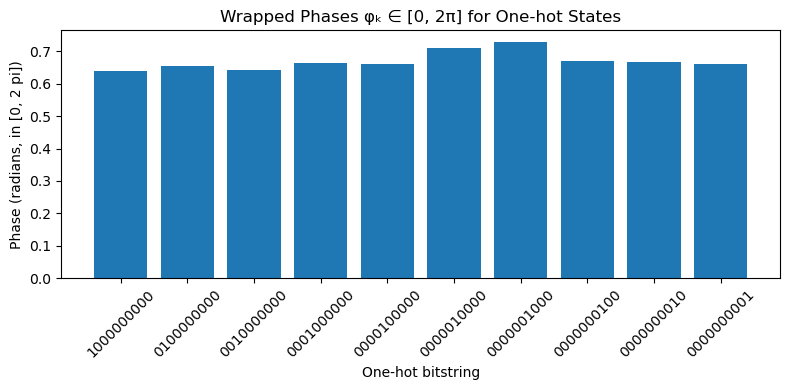

In [26]:
bitstrings = [''.join('1' if val > 0.5 else '0' for val in row) for row in one_hot_states]
phases_np = np.array(phases_model_wrapped)

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(bitstrings, phases_np)
ax.set_xlabel("One-hot bitstring")
ax.set_ylabel("Phase (radians, in [0, 2 pi])")
ax.set_title("Wrapped Phases φₖ ∈ [0, 2π] for One-hot States")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

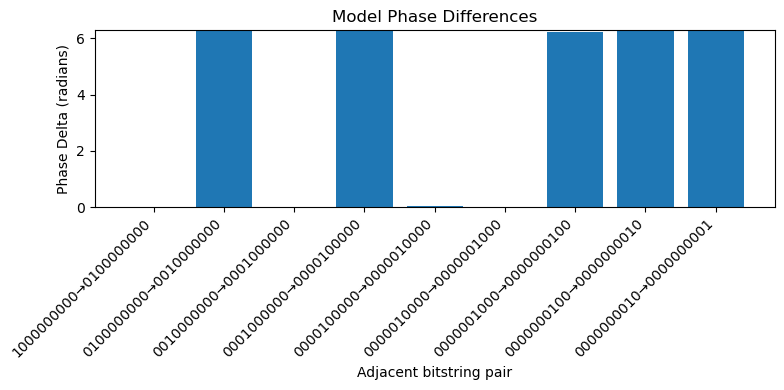

In [27]:

delta = (phases_np[1:] - phases_np[:-1]) % (2*np.pi)
edge_labels = [f"{bitstrings[j]}→{bitstrings[j+1]}" for j in range(len(delta))]

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(edge_labels, delta)
ax.set_ylabel("Phase Delta (radians)")
ax.set_xlabel("Adjacent bitstring pair")
ax.set_title("Model Phase Differences")
plt.xticks(rotation=45, ha="right")
ax.set_ylim(0, 2 * np.pi)
plt.tight_layout()
plt.show()

In [12]:
def load_state_vector_txt(file_path: Path) -> dict:
    state_dict = {}
    with open(file_path, "r") as f:
        for line in f:
            if not line.strip():
                continue
            bitstring, rest = line.strip().split(": ")
            complex_str = rest.split(" + ")[0]
            state_dict[bitstring] = complex(complex_str)
    return state_dict


data_dir = Path("data")
file_path_txt = data_dir / "w_aug_state.txt"
state_vector_dict = load_state_vector_txt(file_path_txt)

# use bitstrings to access all one-hot states
reference_amplitudes = [state_vector_dict[bs] for bs in bitstrings]
reference_phases_raw = np.angle(reference_amplitudes)  # get raw phases in radians
reference_phases_wrapped = reference_phases_raw % (2 * jnp.pi)
bitstring_amplitude_pairs = list(zip(bitstrings, reference_amplitudes, reference_phases_raw, reference_phases_wrapped))

# Display the bitstrings and their corresponding phases
for bitstring, amp, phase_raw, phase_wrapped in bitstring_amplitude_pairs:
    print(f"{bitstring}: ampl: {amp:.4f} (ampl), {phase_raw:.4f} (raw), {phase_wrapped:.4f} (wrapped)")

1000000000: ampl: 0.0500-0.3127j (ampl), -1.4122 (raw), 4.8710 (wrapped)
0100000000: ampl: -0.2900+0.1185j (ampl), 2.7537 (raw), 2.7537 (wrapped)
0010000000: ampl: 0.2000-0.2454j (ampl), -0.8870 (raw), 5.3962 (wrapped)
0001000000: ampl: -0.1000-0.2991j (ampl), -1.8935 (raw), 4.3897 (wrapped)
0000100000: ampl: 0.2600+0.1764j (ampl), 0.5961 (raw), 0.5961 (wrapped)
0000010000: ampl: 0.3100-0.0482j (ampl), -0.1544 (raw), 6.1288 (wrapped)
0000001000: ampl: 0.0200-0.3155j (ampl), -1.5075 (raw), 4.7757 (wrapped)
0000000100: ampl: 0.0700-0.3081j (ampl), -1.3474 (raw), 4.9358 (wrapped)
0000000010: ampl: 0.2200+0.2279j (ampl), 0.8031 (raw), 0.8031 (wrapped)
0000000001: ampl: -0.3000+0.0970j (ampl), 2.8289 (raw), 2.8289 (wrapped)


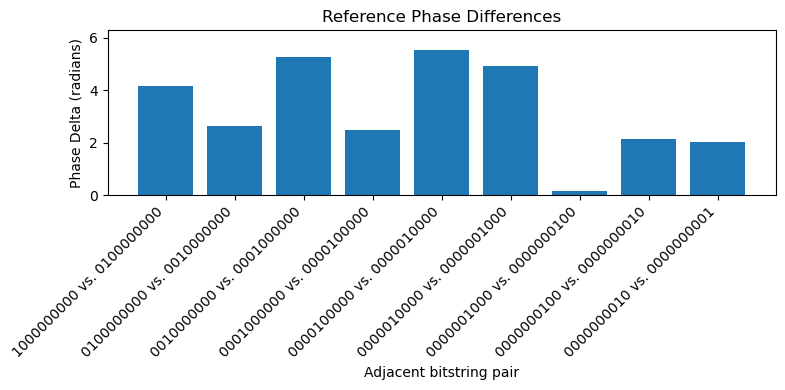

In [13]:
#fig, ax = plt.subplots(figsize=(8, 4))
#ax.bar(bitstrings, reference_phases_wrapped)
#ax.set_xlabel("One-hot bitstring")
#ax.set_ylabel("Phase (radians)")
#ax.set_title("Reference Phases")
#plt.xticks(rotation=45)
#plt.tight_layout()
#plt.show()

delta = (reference_phases_wrapped[1:] - reference_phases_wrapped[:-1]) % (2*np.pi)
edge_labels = [f"{bitstrings[j]} vs. {bitstrings[j+1]}" for j in range(len(delta))]

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(edge_labels, delta)
ax.set_ylabel("Phase Delta (radians)")
ax.set_xlabel("Adjacent bitstring pair")
ax.set_title("Reference Phase Differences")
plt.xticks(rotation=45, ha="right")
ax.set_ylim(0, 2 * np.pi)
plt.tight_layout()
plt.show()